# 0. Imports packages, modules and functions

## 0.1. Import modules

In [161]:
import pandas                   as pd
import numpy                    as np
import seaborn                  as sns
import matplotlib.pyplot        as plt
import umap.umap_               as ump

from plotly      import express as px

from scipy                      import stats
from scipy.cluster              import hierarchy    as hc 
from sklearn                    import cluster
from sklearn                    import decomposition
from sklearn                    import metrics
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, StandardScaler
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer

import datetime
import inflection
import math
import random
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## 0.2. Helper functions

In [105]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corrected = chi2 - ((k - 1)*(r - 1))/(n - 1)
    k_corrected = k - ((k - 1)**2)/(n - 1)
    r_corrected = r - ((r - 1)**2)/(n - 1)
    
    return np.sqrt((chi2_corrected/n) / (min(k_corrected - 1, r_corrected - 1)))

def get_class_count(df, identification, target_var):
    
    class_count = df.groupby([target_var])[identification].nunique()
    return {key: class_count[key] for key in list(class_count.keys())}

def get_class_proportion(df, identification, target_var):
    
    class_counts = get_class_count(df, identification , target_var)
    return {val[0]: round(100 * val[1]/df.shape[0], 2) for val in class_counts.items()}

def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df

def silhouette_analysis(n_clusters, labels, data):
    '''
    Functions that analyzes the silhouette of a previous trained clustering model, for n chosen clusters and data.
    
    param n_clusters
    List of integers representing the number of clusters that will be analyzed.
    
    param labels
    Array of labels obtained from the model prediction. Attention that the data used to create the labels, must be coherent with the data used in this function.
    
    param data
    The dataframe used to generate the labels.
    '''
    from sklearn.metrics import silhouette_samples
    
    fig, ax = plt.subplots( int(len(n_clusters)/2.0) + 1, 2 )
    fig.set_size_inches(25,20)
    
    for k in n_clusters:
        
        q,mod = divmod(k, 2)
        
        ax[q-1, mod].set_xlim([-0.1, 1])
        ax[q-1, mod].set_ylim([0, len(data)])
        
        silhouette_samples_values = silhouette_samples(data, labels)
        
        y_start = 0
        
        for i in range(k):
            
            # selecting the cluster i
            i_th_samples = silhouette_samples_values[labels == i]
            
            # sorting the values
            i_th_samples.sort()
            
            # sizing the cluster i
            size_cluster_i = i_th_samples.shape[0]
            y_end = y_start + size_cluster_i
            
            # updating the color
            cmap = cm.get_cmap('Spectral')
            color = cmap(i / k)
            
            # ploting the silhouette for cluster i
            ax[q-1,mod].fill_betweenx(np.arange(y_start, y_end), 0, i_th_samples)
            
            # updating y axis
            y_start = y_end
            
        ax[q-1,mod].set_yticks([])
        ax[q-1,mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
    plt.show()

## 0.3. Loading data

In [106]:
 # load data
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv', encoding = "ISO-8859-1" )

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

## 0.4. Image controls

In [107]:
 def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 15]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. Data description

In [108]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [109]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [110]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = cols_new
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.2. Data dimensions

In [111]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


The dataset consist of more than 500,000 items purchases with different purchases must refer to the same purchase order and customer, while it has only 8 columns.

## 1.3. Data types

In [112]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

The types of the invoice number, customer id and invoice date seem to have the wrong type. Customer ID and invoice number should be represented by the int number type, while the invoice date should be represented by a datetime.

## 1.4. Check NA

In [113]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replacing NA

In [114]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# Coalescing columns customer_id_x and customer_id_y
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# Droping extra customer_id columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [115]:
df1 = df1.dropna(subset=['description', 'customer_id'])

print('Removed data: {:.2f}%'.format(100*(1 - (df1.shape[0]/df_raw.shape[0]))))

Removed data: 0.27%


In [116]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

The data has many problems with NA purchase orders, that may be represented by some business problem or relevant information, such as reversed logistics to product change or devolution. It can be represented by both the negative quantities and the letters whitin the invoice number. All those data will be removed from the dataset.

## 1.6. Change dtypes

In [117]:
 # invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [118]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

Even after the removal of NA values, it was not possible to remove all invoice numbers with a letter in it. So, it was not possible to change the invoice number type. Maybe it could be necessary to create features that properly represents the business problem behind the reason of a letter to appear in it. 

## 1.7. Descriptive statistics

It is intended to solve the clusterization problem with the RFM model, the descriptive statistics will be done again after the creation of the variables necessary to create the model.

In [119]:
num_att = df1.select_dtypes(include=['int64', 'float64'])
cat_att = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical attributes

In [120]:
# Central tendency - mean, median

mean = pd.DataFrame(num_att.apply(np.mean)).T
median = pd.DataFrame(num_att.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

std_deviation = pd.DataFrame(num_att.apply(np.std)).T
min_value = pd.DataFrame(num_att.apply(min)).T
max_value = pd.DataFrame(num_att.apply(max)).T
range_values = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

desc_stat = pd.concat([min_value, max_value, range_values, mean, median, std_deviation, skew, kurtosis]).T.reset_index()
desc_stat.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
desc_stat

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.603129,3.00,218.007397,-0.281253,120252.449063
1,unit_price,-11062.06,38970.0,50032.06,4.623519,2.08,96.889538,186.257919,58848.017575
2,customer_id,12346.00,22709.0,10363.00,16678.153600,16241.00,2907.570262,0.493600,-0.792496


From the results we can observe values of standard deviation one order higher than the mean and the median, also with negative values. For the unit price, we can see that there are some occurrencies of products with price 0.

### 1.7.2. Categorical attributes

In [121]:
strings1 = len( cat_att.loc[ cat_att['invoice_no'].apply( lambda x: bool(re.search( '[^0-9]+', x ) ) ), 'invoice_no' ].drop_duplicates() )
strings2 = len( cat_att.loc[ cat_att['stock_code'].apply( lambda x: bool(re.search( '[^0-9]+', x ) ) ), 'stock_code' ].drop_duplicates() )
strings3 = len(cat_att.loc[ cat_att['stock_code'].apply( lambda x: bool(re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code' ])

strings = cat_att.loc[ cat_att['stock_code'].apply( lambda x: bool(re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code' ].unique()

total1 = len(cat_att['invoice_no'].drop_duplicates())
total2 = len(cat_att['stock_code'].drop_duplicates())

perc1 = 100 * strings1 / total1
perc2 = 100 * strings2 / total2

In [122]:
print('There are a total of {}/{} ({:,.2f} %)) different invoice numbers with a letter in it, {}/{} ({:,.2f} %) different stock codes with a letter in it and {} appearances of the letters {} as a stock code'.format( strings1, total1, perc1, strings2, total2, perc2, strings3, strings ))

There are a total of 3839/24446 (15.70 %)) different invoice numbers with a letter in it, 1073/3958 (27.11 %) different stock codes with a letter in it and 2754 appearances of the letters ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK'] as a stock code


# 2. Variable filtering

In [123]:
df2 = df1.copy()

All values of clients with a quantity equal or lesser than 0 will be removed from the dataset, since this type of customer will not be elected as a insider anyway. Afterwards, the quantity column will be removed, since its information is contained inside the ticket per product.

In [124]:
# prices higher than 1 cent
df2 = df2.loc[(df1['unit_price'] > 0.01), :]

# customer from a known region
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified' ] ) ]

# stock code different from not explained codes
df2 = df2[~df2['stock_code'].isin( ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS' 'B' 'CRUK'] ) ]

# returned products
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_returns['gross_returns'] = df2_returns['quantity'] * df2_returns['unit_price'] * (- 1)

# positive quantities
df2_purchase = df2.loc[(df2['quantity'] > 0), :]
df2_purchase.loc[:,'gross_purchases'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unit_price']


# 3. Feature engineering

In [125]:
df3 = df2.copy()

## 3.1. Feature creation

The features will be created in order to adjust the clusterization problem with a RFM model solution. For this, the main features within the model will be the monetary, frequency and recency. The monetary consists of the total amount of revenue from a given client, the frequency measures how many different purchases the client has made, while the recency measures the difference between the actual date (highest date within the dataset) and the last purchase date.

In [126]:
 # data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'description', 'quantity',
                    'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates().reset_index(drop=True)

### 3.1.1. Gross purchases and devolutions

In [127]:
# Purchases
df3['purchases'] = df2_purchase['quantity'] * df2_purchase['unit_price']
df3['devolutions'] = df2_returns['quantity'] * df2_returns['unit_price']

# Monetary
df_monetary = df3[['customer_id', 'purchases', 'devolutions']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions
0,17850,5391.21,-102.58
1,13047,3237.54,-158.44
2,12583,7281.38,-94.04
3,13748,948.25,0.00
4,15100,876.00,-240.90
5,15291,4668.30,-71.79
6,14688,5630.87,-523.49
7,17809,5411.91,-784.29
8,15311,60767.90,-1348.56
9,14527,8508.82,-797.44


### 3.1.2. Recency for purchases and devolutions - newest occurence

In [128]:
# Recency - Last day purchase
df_recency_p = df2_purchase[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency_p['recency_p'] = ( df3['invoice_date'].max() - df_recency_p['invoice_date'] ).dt.days
df_recency_p = df_recency_p[['customer_id', 'recency_p']].copy()
df_ref = pd.merge( df_ref, df_recency_p, on='customer_id', how='left' )

# Recency - Last day devolution
df_recency_d = df2_returns[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency_d['recency_d'] = ( df3['invoice_date'].max() - df_recency_d['invoice_date'] ).dt.days
df_recency_d = df_recency_d[['customer_id', 'recency_d']].copy()
df_ref = pd.merge( df_ref, df_recency_d, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions,recency_p,recency_d
0,17850,5391.21,-102.58,372.0,302.0
1,13047,3237.54,-158.44,31.0,31.0
2,12583,7281.38,-94.04,2.0,56.0
3,13748,948.25,0.00,95.0,NaN
4,15100,876.00,-240.90,333.0,330.0
5,15291,4668.30,-71.79,25.0,172.0
6,14688,5630.87,-523.49,7.0,7.0
7,17809,5411.91,-784.29,16.0,16.0
8,15311,60767.90,-1348.56,0.0,0.0
9,14527,8508.82,-797.44,2.0,8.0


### 3.1.3. Quantity of product pruchased or returned

In [129]:
# Frequency - both purchases and returns
df_freq_p = df2_purchase[['customer_id', 'quantity']].drop_duplicates().groupby( 'customer_id' ).sum().reset_index().rename(columns={'quantity':'quantity_p'})
df_ref = pd.merge( df_ref, df_freq_p, on='customer_id', how='left' )

df_freq_d = df2_returns[['customer_id', 'quantity']].drop_duplicates().groupby( 'customer_id' ).sum().reset_index().rename(columns={'quantity':'quantity_d'})
df_ref = pd.merge( df_ref, df_freq_d, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d
0,17850,5391.21,-102.58,372.0,302.0,35.0,-21.0
1,13047,3237.54,-158.44,31.0,31.0,132.0,-6.0
2,12583,7281.38,-94.04,2.0,56.0,1569.0,-50.0
3,13748,948.25,0.00,95.0,NaN,169.0,NaN
4,15100,876.00,-240.90,333.0,330.0,48.0,-22.0
5,15291,4668.30,-71.79,25.0,172.0,508.0,-27.0
6,14688,5630.87,-523.49,7.0,7.0,579.0,-281.0
7,17809,5411.91,-784.29,16.0,16.0,961.0,-41.0
8,15311,60767.90,-1348.56,0.0,0.0,2167.0,-231.0
9,14527,8508.82,-797.44,2.0,8.0,198.0,-3.0


### 3.1.4. Quantity of invoices for purchases and returns

In [130]:
# Frequency - both purchases and returns
df_invoices_p = df2_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename(columns={'invoice_no':'invoices_p'})
df_ref = pd.merge( df_ref, df_invoices_p, on='customer_id', how='left' )

df_invoices_d = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename(columns={'invoice_no':'invoices_d'})
df_ref = pd.merge( df_ref, df_invoices_d, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d,invoices_p,invoices_d
0,17850,5391.21,-102.58,372.0,302.0,35.0,-21.0,34.0,1.0
1,13047,3237.54,-158.44,31.0,31.0,132.0,-6.0,10.0,8.0
2,12583,7281.38,-94.04,2.0,56.0,1569.0,-50.0,15.0,3.0
3,13748,948.25,0.00,95.0,NaN,169.0,NaN,5.0,NaN
4,15100,876.00,-240.90,333.0,330.0,48.0,-22.0,3.0,3.0
5,15291,4668.30,-71.79,25.0,172.0,508.0,-27.0,15.0,5.0
6,14688,5630.87,-523.49,7.0,7.0,579.0,-281.0,21.0,6.0
7,17809,5411.91,-784.29,16.0,16.0,961.0,-41.0,12.0,3.0
8,15311,60767.90,-1348.56,0.0,0.0,2167.0,-231.0,91.0,27.0
9,14527,8508.82,-797.44,2.0,8.0,198.0,-3.0,55.0,31.0


### 3.1.5. Average ticket value

In [131]:
# average ticket - for purchases only
df_avg_ticket = df2_purchase.loc[:,['customer_id', 'gross_purchases']].groupby('customer_id').mean().reset_index().rename(columns={'gross_purchases':'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d,invoices_p,invoices_d,avg_ticket
0,17850,5391.21,-102.58,372.0,302.0,35.0,-21.0,34.0,1.0,18.152222
1,13047,3237.54,-158.44,31.0,31.0,132.0,-6.0,10.0,8.0,18.822907
2,12583,7281.38,-94.04,2.0,56.0,1569.0,-50.0,15.0,3.0,29.479271
3,13748,948.25,0.00,95.0,NaN,169.0,NaN,5.0,NaN,33.866071
4,15100,876.00,-240.90,333.0,330.0,48.0,-22.0,3.0,3.0,292.000000
5,15291,4668.30,-71.79,25.0,172.0,508.0,-27.0,15.0,5.0,45.323301
6,14688,5630.87,-523.49,7.0,7.0,579.0,-281.0,21.0,6.0,17.219786
7,17809,5411.91,-784.29,16.0,16.0,961.0,-41.0,12.0,3.0,88.719836
8,15311,60767.90,-1348.56,0.0,0.0,2167.0,-231.0,91.0,27.0,25.543464
9,14527,8508.82,-797.44,2.0,8.0,198.0,-3.0,55.0,31.0,8.753930


### 3.1.6. Average recency days

In [132]:
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'], ascending=['True','False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift(-1) # next customer
df_aux['next_next_customer_id'] = df_aux['next_customer_id'].shift(-1) # next customer
df_aux['next_invoice_date'] = df_aux['invoice_date'].shift(-1) # next invoice date

#today =  datetime.datetime.fromtimestamp(df3['invoice_date'].max().to_datetime())
#today_date = datetime.datetime.strptime( today, '%Y-%m-%d')
today_date = df3['invoice_date'].max()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['next_invoice_date'] - x['invoice_date']).days if (x['customer_id'] == x['next_customer_id']) 
                                                                                                    else ( (x['next_invoice_date'] - x['invoice_date']) if (x['customer_id'] == x['next_next_customer_id']) 
                                                                                                                                                        else (today_date - x['invoice_date']).days), axis=1)
df_avg_recency_days = df_aux[['customer_id','avg_recency_days']].groupby('customer_id').mean().reset_index()

# Merging
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')

print(df_aux.head(10))
print(df_ref.head())

        customer_id invoice_date  next_customer_id  next_next_customer_id next_invoice_date  avg_recency_days
61619         12346   2017-01-16           12347.0                12347.0        2016-12-05               325
14938         12347   2016-12-05           12347.0                12347.0        2017-01-24                50
72246         12347   2017-01-24           12347.0                12347.0        2017-04-05                71
148285        12347   2017-04-05           12347.0                12347.0        2017-06-07                63
220572        12347   2017-06-07           12347.0                12347.0        2017-07-31                54
286621        12347   2017-07-31           12347.0                12347.0        2017-10-29                90
428957        12347   2017-10-29           12347.0                12348.0        2017-12-05                37
535004        12347   2017-12-05           12348.0                12348.0        2016-12-14                 2
34083     

### 3.1.7. Basket size and unique products

In [133]:
df_aux = ( df2_purchase.loc[:,['customer_id','invoice_no','quantity']].groupby('customer_id')
                                                                       .agg(n_purchase=('invoice_no', 'nunique'),
                                                                            n_products=('quantity', 'sum'))
                                                                       .reset_index() )

df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')

df_aux = ( df2_purchase.loc[:,['customer_id','invoice_no','stock_code']].groupby('customer_id')
                                                                       .agg(n_purchase=('invoice_no', 'nunique'),
                                                                            n_products=('stock_code', 'count'))
                                                                       .reset_index() )

df_aux['avg_variety'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')

### 3.1.8. Frequency - purchases per day

In [134]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg( max_=('invoice_date', 'max'),
                                                                  min_=('invoice_date', 'min'),
                                                                  buys_=('invoice_no','count'))
                                                            .reset_index()  )
# Calculating the days
df_aux['days_'] = df_aux[['max_','min_']].apply(lambda x: (x['max_'] - x['min_']).days + 1 , axis=1)

# Frequency
df_aux['purchases_pday'] = df_aux[['buys_','days_']].apply(lambda x: x['buys_'] / x['days_'] if (x['days_'] !=0 ) else 0, axis=1)

# Merging
df_ref = pd.merge(df_ref, df_aux[['customer_id','purchases_pday']], on='customer_id', how='left')
df_ref.sample(20)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d,invoices_p,invoices_d,avg_ticket,avg_recency_days,n_purchase_x,n_products_x,avg_basket_size,n_purchase_y,n_products_y,avg_variety,purchases_pday
4937,16101,1290.70,-44.74,70.0,9.0,111.0,-9.0,1.0,2.0,16.982895,23.333333,1.0,757.0,757.000000,1.0,76.0,76.000000,1.000000
13,16029,81024.84,-30032.23,38.0,52.0,10828.0,-4873.0,63.0,13.0,334.813388,8.288889,63.0,40208.0,638.222222,63.0,242.0,3.841270,0.187500
5411,15748,149.31,0.00,40.0,NaN,16.0,NaN,1.0,NaN,7.110000,40.000000,1.0,51.0,51.000000,1.0,21.0,21.000000,1.000000
626,13240,663.65,0.00,96.0,NaN,52.0,NaN,4.0,NaN,9.905224,91.250000,4.0,298.0,74.500000,4.0,67.0,16.750000,0.014815
2189,15622,3709.56,-485.03,43.0,3.0,159.0,-58.0,9.0,7.0,20.051676,23.500000,9.0,1674.0,186.000000,9.0,185.0,20.555556,0.037500
2689,20052,1385.13,0.00,255.0,NaN,84.0,NaN,1.0,NaN,8.244821,255.000000,1.0,357.0,357.000000,1.0,168.0,168.000000,1.000000
2179,19754,1734.52,0.00,283.0,NaN,167.0,NaN,1.0,NaN,10.840750,283.000000,1.0,429.0,429.000000,1.0,160.0,160.000000,1.000000
888,15822,885.47,0.00,3.0,NaN,133.0,NaN,2.0,NaN,26.832424,179.500000,2.0,375.0,187.500000,2.0,33.0,16.500000,0.005602
2655,20006,0.00,-684.91,NaN,256.0,NaN,-1.0,NaN,1.0,NaN,256.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2413,16061,0.00,-29.95,NaN,269.0,NaN,-1.0,NaN,1.0,NaN,269.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
df_ref.isna().sum()

customer_id            0
purchases              0
devolutions            0
recency_p            215
recency_d           4201
quantity_p           215
quantity_d          4201
invoices_p           215
invoices_d          4201
avg_ticket           215
avg_recency_days       0
n_purchase_x         215
n_products_x         215
avg_basket_size      215
n_purchase_y         215
n_products_y         215
avg_variety          215
purchases_pday       215
dtype: int64

In [136]:
print( 'Number of rows: {}'.format( df_ref.shape[0] ) )
print( 'Number of cols: {}'.format( df_ref.shape[1] ) )

Number of rows: 5971
Number of cols: 18


## 3.2. Feature engineering

In [137]:
df_ref = df_ref.drop(['n_purchase_x', 'n_purchase_y', 'n_products_x', 'n_products_y'], axis=1)

df_ref['devolutions'] = df_ref['devolutions'].apply(lambda x: (-1*x) if x < 0   else x )

df_ref['quantity_d'] = df_ref['quantity_d'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['recency_d'] = df_ref['recency_d'].apply( lambda x: 365 if math.isnan(x) else x )
df_ref['quantity_d'] = df_ref['quantity_d'].apply( lambda x: 0.00 if math.isnan(x) else x*(-1) )
df_ref['invoices_d'] = df_ref['invoices_d'].apply( lambda x: 0.00 if math.isnan(x) else x )

df_ref['quantity_p'] = df_ref['quantity_p'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['recency_p'] = df_ref['recency_p'].apply( lambda x: 365 if math.isnan(x) else x )
df_ref['quantity_p'] = df_ref['quantity_p'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['invoices_p'] = df_ref['invoices_p'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['avg_ticket'] = df_ref['avg_ticket'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['purchases_pday'] = df_ref['purchases_pday'].apply( lambda x: 0.00 if math.isnan(x) else x )

df_ref['avg_variety'] = df_ref['avg_variety'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['avg_basket_size'] = df_ref['avg_basket_size'].apply( lambda x: 0.00 if math.isnan(x) else x )

df_ref.sample(10)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d,invoices_p,invoices_d,avg_ticket,avg_recency_days,avg_basket_size,avg_variety,purchases_pday
2673,17874,683.46,25.20,185.0,225.0,135.0,12.0,6.0,1.0,14.857826,85.000000,36.833333,7.666667,0.084507
3747,20918,0.00,106.53,365.0,178.0,0.0,1.0,0.0,1.0,0.000000,178.000000,0.000000,0.000000,0.000000
3631,16825,775.18,0.00,38.0,365.0,210.0,-0.0,2.0,0.0,27.685000,92.500000,283.000000,14.000000,0.013514
1568,13098,28882.44,223.56,1.0,3.0,1936.0,21.0,28.0,13.0,50.493776,9.323529,570.285714,20.428571,0.088328
4274,15118,244.80,0.00,134.0,365.0,1440.0,-0.0,1.0,0.0,244.800000,134.000000,1440.000000,1.000000,1.000000
5867,13521,1093.65,0.00,1.0,365.0,46.0,-0.0,3.0,0.0,2.508372,3.333333,245.333333,145.333333,0.300000
5882,17911,366.23,0.00,9.0,365.0,100.0,-0.0,1.0,0.0,9.390513,9.000000,223.000000,39.000000,1.000000
3910,21035,749.72,0.00,165.0,365.0,40.0,-0.0,1.0,0.0,12.707119,165.000000,121.000000,59.000000,1.000000
718,14107,2703.23,14.75,51.0,354.0,180.0,5.0,7.0,1.0,21.977480,45.500000,256.142857,17.571429,0.022293
814,13008,229.47,51.00,323.0,360.0,65.0,60.0,1.0,1.0,16.390714,180.000000,175.000000,14.000000,1.000000


In [138]:
df_ref['gross_revenue'] = (df_ref['purchases'] - df_ref['devolutions'])
df_ref['relative_revenue'] = (df_ref['purchases'] - df_ref['devolutions']) / (df_ref['purchases'] + df_ref['devolutions'])
df_ref['relative_quantity'] = (df_ref['quantity_p'] - df_ref['quantity_d']) / (df_ref['quantity_p'] + df_ref['quantity_d'])

#df_ref['relative_invoices'] = (df_ref['invoices_p'] - df_ref['invoices_d'])
#df_ref = df_ref.drop(columns=['purchases','devolutions','invoices_p','invoices_d','recency_d'], axis=1)

In [140]:
df_ref.isna().sum()
total_variety = len(df2['description'].drop_duplicates())
total_variety

#print( math.log( (df_ref['avg_variety'].mean()), 10))

4041

There were a problem whith clients that did not have made any purchase in the analyzed period or did not have done any devolution. For those clients, recency was considered as 365 days or 1 year and the frequency of purchase or devolution was considered 0.

# 4. Exploratory data analysis

In [149]:
df4 = df_ref.copy()

In [150]:
# filter to analyze only valid customers
# returned products
df4 = df4.loc[df4['customer_id'] <19000, :]

### 4.1.1. Looking for outliers

- Features for attention
    - quantity_p for values above 20k
    - quantity_d for values above 4k
    - avg_ticket for values above 4k
    - avg_basket_size for values above 4k
    - purchases_pday for value 17
    - gross_revenue for above 70k
- Features with high correlation
    - recency_p w/ avg_recency_days
    - quantity_p w/ quantity_d
    - quantity_p w/ avg_basket_size
    - quantity_p w/ gross_revenue
    - quantity_d w/ relative variables (all)
    - relative variables are highly correlated between themselves

It seems that customers 12346 and 16446 had some problem with the data quality in database, since they have bought a high number of items and returned them. They will be removed from the dataset in order to increase the model result. Other customers with a high number of returns also had a high number of purchases, which seems reasonable.

Again, clients 12346 and 16446 shows as an outliers to the average ticket, due to the high amount of items purchases, however with no gross revenue. At this point, it seems that customers 15098 also had some problem, since it has a liquid purchased quantity of 0, however with some gross revenue (purchases higher than returns), this customer will also be removed from the dataset. Also customer 15749 have the same behavior as 15098 and will be removed.

All clients with gross revenue higher than 50000 seems to behave similarly, with small values for recency of purchases and high values for relative revenue and relative invoices (where 1 means that the customer has only purchases and -1 meaning that the customer only returns). At this point, only 4 customers will be considered as outliers and removed from the dataset: 12346,15098,15749,16446.

In [151]:
customers_outliers = [12346,15098,15749,16446]
df4 = df4[~df4['customer_id'].isin(customers_outliers)]

## 4.3. Data space analysis

In [152]:
data_space = df4.copy()
customers_to_cluster = data_space['customer_id']
data_space = data_space.drop(columns=['customer_id', 'purchases', 'recency_d', 'quantity_d', 'invoices_p', 'invoices_d', 'avg_basket_size', 'purchases_pday','relative_revenue', 'relative_quantity'], axis=1)

rs = RobustScaler()
mm = MinMaxScaler()
ss = StandardScaler()

#data_space['purchases'] = mm.fit_transform( data_space[['purchases']].values )
data_space['devolutions'] = mm.fit_transform( data_space[['devolutions']].values )
#data_space['purc_dev'] = rs.fit_transform( data_space[['purc_dev']].values )
data_space['recency_p'] = rs.fit_transform( data_space[['recency_p']].values )
#data_space['recency_d'] = rs.fit_transform( data_space[['recency_d']].values )
data_space['quantity_p'] = mm.fit_transform( data_space[['quantity_p']].values )
#data_space['quantity_d'] = mm.fit_transform( data_space[['quantity_d']].values )
#data_space['invoices_p'] = rs.fit_transform( data_space[['invoices_p']].values )
#data_space['invoices_d'] = rs.fit_transform( data_space[['invoices_d']].values )

data_space['gross_revenue'] = mm.fit_transform( data_space[['gross_revenue']].values )
data_space['avg_ticket'] = mm.fit_transform( data_space[['avg_ticket']].values )
data_space['avg_recency_days'] = rs.fit_transform( data_space[['avg_recency_days']].values )
data_space['avg_variety'] = mm.fit_transform( data_space[['avg_variety']].values )
#data_space['avg_variety'] = rs.fit_transform( data_space[['avg_variety']].values )
#data_space['relative_quantity'] = rs.fit_transform( data_space[['relative_quantity']].values )
#data_space['relative_invoices'] = rs.fit_transform( data_space[['relative_invoices']].values )
#data_space['purchases_pday'] = rs.fit_transform( data_space[['purchases_pday']].values )

#data_space['monetary_score'] = ss.fit_transform( data_space[['ticket_score']].values )
#data_space['ticket_score'] = ss.fit_transform( data_space[['ticket_score']].values )
#data_space['recency_score'] = ss.fit_transform( data_space[['recency_score']].values )
#data_space['behavior_score'] = ss.fit_transform( data_space[['behavior_score']].values )

### 4.3.4. Tree-based embedding

In [153]:
# training dataset
x_trees = data_space.drop(columns=['gross_revenue'], axis=1)
y_trees = data_space['gross_revenue']

#model definition
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(x_trees, y_trees)

#Leaves
df_leaf = pd.DataFrame(rf_model.apply(x_trees))

#Leaves dataFrame
df_leaf.shape

(4362, 100)

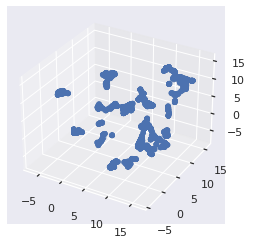

<Figure size 720x720 with 0 Axes>

In [154]:
n_components=3

reducer = ump.UMAP( random_state=42, n_components=n_components )
embedding = reducer.fit_transform(df_leaf)

#df_leaf['embedding_x'] = embedding[:,0]
#df_leaf['embedding_y'] = embedding[:,1]
#df_leaf['embedding_z'] = embedding[:,2]

fig = plt.figure()

if n_components == 1:

    df_leaf['embedding_x'] = embedding[:,0]

    ax = fig.add_subplot(111)
    ax.scatter(df_leaf['embedding_x'], range(len(df_leaf[['embedding_x']])))
elif n_components == 2:

    df_leaf['embedding_x'] = embedding[:,0]
    df_leaf['embedding_y'] = embedding[:,1]
    
    ax = fig.add_subplot(111)
    ax.scatter(df_leaf['embedding_x'], df_leaf['embedding_y'])
elif n_components == 3:
    
    df_leaf['embedding_x'] = embedding[:,0]
    df_leaf['embedding_y'] = embedding[:,1]
    df_leaf['embedding_z'] = embedding[:,2]
    
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_leaf['embedding_x'], df_leaf['embedding_y'], df_leaf['embedding_z'])

plt.figure(figsize=(10,10))

plt.show()

In [156]:
df_leaf['customer_id'] = customers_to_cluster
#for i in range(len(df_leaf), 1):
#    df_leaf.loc[i,'customer_id'] = customers_to_cluster[i]

# 5. Data preparation

**Rules of thumb**

Standardization -> assumption that the feature follows a normal distribution (test for normal distribution QQ Plot or KS Test)
Rescale         -> assumption that the feature does not follow a normal distribution

**Based on features:**
1. Normal distribution and abscence of outliers -> Standard scaler;
2. Normal distribution and have outliers        -> Robust scaler;
3. Does not follow a normal distribution        -> Min-max scaler;

## 5.1. Data rescaling

In [157]:
df_rescaled = df4.copy()
#df_rescaled = data_space.copy()
df_rescaled = df_rescaled.drop(columns=['purchases', 'recency_d', 'quantity_d', 'invoices_p', 'invoices_d', 'avg_basket_size', 'purchases_pday','relative_revenue', 'relative_quantity'], axis=1)

rs = RobustScaler()
mm = MinMaxScaler()
ss = StandardScaler()

In [158]:
#data_space['purchases'] = mm.fit_transform( data_space[['purchases']].values )
data_space['devolutions'] = mm.fit_transform( data_space[['devolutions']].values )
#data_space['purc_dev'] = rs.fit_transform( data_space[['purc_dev']].values )
data_space['recency_p'] = rs.fit_transform( data_space[['recency_p']].values )
#data_space['recency_d'] = rs.fit_transform( data_space[['recency_d']].values )
data_space['quantity_p'] = mm.fit_transform( data_space[['quantity_p']].values )
#data_space['quantity_d'] = mm.fit_transform( data_space[['quantity_d']].values )
#data_space['invoices_p'] = rs.fit_transform( data_space[['invoices_p']].values )
#data_space['invoices_d'] = rs.fit_transform( data_space[['invoices_d']].values )

data_space['gross_revenue'] = mm.fit_transform( data_space[['gross_revenue']].values )
data_space['avg_ticket'] = mm.fit_transform( data_space[['avg_ticket']].values )
data_space['avg_recency_days'] = rs.fit_transform( data_space[['avg_recency_days']].values )
data_space['avg_variety'] = mm.fit_transform( data_space[['avg_variety']].values )
#data_space['avg_variety'] = rs.fit_transform( data_space[['avg_variety']].values )
#data_space['relative_quantity'] = rs.fit_transform( data_space[['relative_quantity']].values )
#data_space['relative_invoices'] = rs.fit_transform( data_space[['relative_invoices']].values )
#data_space['purchases_pday'] = rs.fit_transform( data_space[['purchases_pday']].values )

#data_space['monetary_score'] = ss.fit_transform( data_space[['ticket_score']].values )
#data_space['ticket_score'] = ss.fit_transform( data_space[['ticket_score']].values )
#data_space['recency_score'] = ss.fit_transform( data_space[['recency_score']].values )
#data_space['behavior_score'] = ss.fit_transform( data_space[['behavior_score']].values )

# 6. Feature selection

# 7. Hyperparameter fine tuning

There are 3 types of major problems within data problems to solve with machine learning algorithms: regression, classification and clusterization. The first two problems, regression and classification, there is a necessity to split the dataset between training and testing and there is a target variable to analyze the accuracy and precision of the model, while the clusterization problems does not have the need in dataset spliting. Because of that, there is a necessity to first determine the number of clusters which the dataset will be split, before training and finding the model.

In [159]:
#df7 = df6.copy()
df7_embbed = df_leaf.copy()
#print(df7.head())
#print(df7_embbed.head())
print(df7_embbed.shape)

(4362, 104)


In [160]:
tree_cols_to_drop = []
for i in range( 0, (df7_embbed.shape[1]-4),1 ):
    tree_cols_to_drop.append(i)
    i = i + 1


X_embbed = df7_embbed.drop(columns=tree_cols_to_drop, axis=1)
X_embbed = X_embbed.drop(columns=['customer_id'], axis=1)
customers_to_cluster = df7['customer_id'].to_list()
X = df7.drop(columns=['customer_id'], axis=0)
print(X.head())
print(X_embbed.head())

   devolutions  recency_p  quantity_p  avg_ticket  avg_recency_days  avg_variety  gross_revenue  cluster
0       102.58      372.0        35.0   18.152222        124.333333     8.735294        5288.63        9
1       158.44       31.0       132.0   18.822907         26.642857    17.200000        3079.10       11
2        94.04        2.0      1569.0   29.479271         20.722222    16.466667        7187.34        1
3         0.00       95.0       169.0   33.866071         93.250000     5.600000         948.25        2
4       240.90      333.0        48.0  292.000000         62.166667     1.000000         635.10        6
   embedding_x  embedding_y  embedding_z
0     1.054695     7.173187     9.336242
1    12.162703    11.087784    -3.617847
2    11.633012     2.327265    15.316863
3    10.791920    -0.056241    -4.320868
4    -0.067407    -0.466358     1.514187


### 7.4.1. Hierarchical clustering on embbeded space

In [164]:
hc_emb_list =[]

for k in clusters:
    # model definition & training
    hc_emb_model = hc.linkage(X_embbed, 'ward')

    # model predict
    labels = hc.fcluster(hc_emb_model, k, criterion='maxclust')

    # model performance
    sil = metrics.silhouette_score(X_embbed, labels, metric='euclidean')
    hc_emb_list.append(sil)

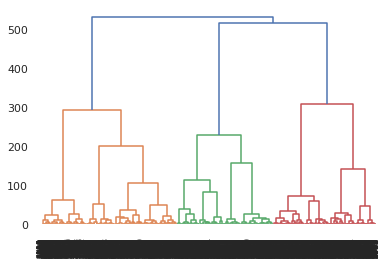

In [165]:
hc.dendrogram(
    hc_emb_model,
    leaf_rotation=90,
    leaf_font_size=8
    )
plt.plot()
plt.show()

# 8. Model training

## 8.1. Hierarchical model

In [166]:
k = 12

# model definition
#gmm_emb_model = mx.GaussianMixture(n_components=k)

# model training
#gmm_emb_model.fit(X_embbed)

# model predict
#labels = gmm_emb_model.predict(X_embbed)

# model performance
#sil = metrics.silhouette_score(X_embbed, labels, metric='euclidean')

#labels = gmm_emb_model.labels_


# model definition & training
hc_emb_model = hc.linkage(X_embbed, 'ward')

# model predict
labels = hc.fcluster(hc_emb_model, k, criterion='maxclust')

# model performance
sil = metrics.silhouette_score(X_embbed, labels, metric='euclidean')

# 9. Cluster analysis

## 9.1. Final model

In [169]:
df9 = df_ref.copy()
df9 = df9[df9['customer_id'].isin(customers_to_cluster)]
df9['cluster'] = labels
#df7['cluster'] = labels
df_leaf['cluster'] = labels
#df9.head(10)


### 9.1.1. Visualization Inspection

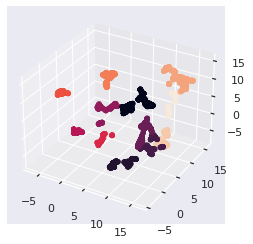

<Figure size 720x720 with 0 Axes>

In [170]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_leaf['embedding_x'], df_leaf['embedding_y'], df_leaf['embedding_z'], c=df_leaf['cluster'])

plt.figure(figsize=(10,10))

plt.show()


### 9.1.4. Cluster profile

The profile of each cluster can be represented as a persona, and the persona is the mean or median behavior of all other customers inside the cluster

In [171]:
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = round(100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum()), 3)

df_gross_revenue = round(df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index(), 2)
df_avg_devolutions = round(df9[['devolutions', 'cluster']].groupby('cluster').mean().reset_index(), 2)
#df_avg_relation = round(df9[['purc_dev','cluster']].groupby('cluster').mean().reset_index() , 2)

df_avg_recency_p = round(df9[['cluster', 'recency_p']].groupby('cluster').mean().reset_index(), 2)
#df_avg_quantity_d = round(df9[['cluster', 'quantity_d']].groupby('cluster').mean().reset_index(), 2)

df_avg_frequency_p = round(df9[['cluster','quantity_p']].groupby('cluster').mean().reset_index(), 2)
#df_avg_frequency_d = round(df9[['cluster','quantity_d']].groupby('cluster').mean().reset_index(), 2)

df_avg_ticket = round(df9[['cluster','avg_ticket']].groupby('cluster').mean().reset_index(), 2)
df_avg_recency_days = round(df9[['cluster','avg_recency_days']].groupby('cluster').mean().reset_index(), 2)
df_avg_variety = round(df9[['cluster','avg_variety']].groupby('cluster').mean().reset_index(), 2)

df_cluster = pd.merge(df_cluster, df_gross_revenue, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_devolutions, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_avg_relation, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_recency_p, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_avg_quantity_d, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_frequency_p, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_avg_frequency_d, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_ticket, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_recency_days, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_variety, on='cluster', how='inner')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,devolutions,recency_p,quantity_p,avg_ticket,avg_recency_days,avg_variety
0,1,595,13.641,7810.70,328.58,44.92,1255.35,93.10,51.16,20.97
1,2,362,8.299,1067.25,0.08,79.12,180.42,32.23,88.44,24.37
2,3,373,8.551,1955.85,83.93,52.44,194.88,21.83,54.07,24.49
3,4,442,10.133,2469.28,55.51,49.61,295.00,28.03,57.45,27.09
4,5,290,6.648,223.71,9.10,157.65,21.88,23.04,152.68,20.48
5,6,154,3.530,212.04,20.21,135.94,43.19,38.38,126.62,5.07
6,7,167,3.829,89.21,14.52,213.46,10.63,35.57,196.61,3.32
7,8,219,5.021,475.54,14.30,129.93,61.74,20.96,123.57,20.92
8,9,424,9.720,370.53,31.81,130.48,44.43,14.01,126.18,24.05
9,10,726,16.644,649.46,13.06,104.52,82.96,21.59,103.90,23.45


# 10. Clusters insights

In [172]:
df10 = df9.copy()

## Hypothesis for insights

1. Affirmation
2. Features comparison or clusters comparison
3. Base value for comparison and classification in true or false for each hypothesis

Example: Cluster | Feature analyzed | Base value for comparison

### Purchase hypothesis

1. More than 80% of Insiders customers use credit card for payment
2. **Insiders clusters have an average ticket of at least 10% higher than any other cluster**
3. **Insiders customers have a basket size higher than 5 products**
4. **Insiders customers have a contribution of at least 10% of the total purchases**
5. **Insiders customers have a smaller proportion of devolutions than the average of all customers**

### Client hypothesis

1. 60% of Insiders customers are single
2. 10% of Insiders customers are aged between 24 - 35 years old
3. 40% of Insiders customers are located in a radius of 50 km
4. 5%  of Insiders customers earn a salary higher than USD 100.000 yearly
5. 90% of Insiders customers have a high education degree

### Product hypothesis

1. 30% of the all products are bought by Insiders customers
2. Insiders customers buys products that have a higher median than the median of all customers
3. 

### Hx. The median of revenues from insiders customers is 10% higher than the median of other customers

In [173]:
insiders_gnv_median = df10.loc[df10['cluster']==1, 'gross_revenue'].median()
total_gnv_median = df10.loc[:,'gross_revenue'].median()

revenue_diff_median = (insiders_gnv_median - total_gnv_median) / total_gnv_median

print('Insiders revenue median is {}% higher than the median revenue'.format(round(revenue_diff_median*100, 2)))

Insiders revenue median is 387.24% higher than the median revenue


### Hx. The percentile of revenue from insiders customers is higher than third quartile

<AxesSubplot:xlabel='gross_revenue'>

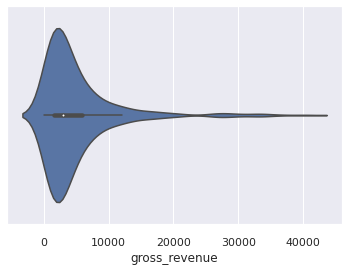

In [174]:
df_aux = df10.loc[(df10['cluster']==1) & (df10['gross_revenue'] < 50000), 'gross_revenue'] 
sns.violinplot(x=df_aux)# hue=df10.loc[df10['cluster'] != 1])

## 10.1. Business questions

### 1. Who are electible to participate in the Insiders program?

In [175]:
df10.loc[df10['cluster']==1, 'customer_id'].head()

2    12583
5    15291
6    14688
7    17809
8    15311
Name: customer_id, dtype: int64

### 2. How many customers will be part of the group?

In [176]:
df10.loc[df10['cluster']==1, 'customer_id'].size

595

### 3. What are the main characteristic of those customers?

    - Gross revenue: $7810.07;
    - Returns: $328.58;
    - Recency of last purchase: 44.92 dias;
    - Quantity of products bought: 1255 products;
    - Average ticket: $93.10;
    - Average time between purchases: 51.16 days;
    - Average variety of products purchased: 20.97.

### 4. What are the contribution of those customers in revenue?

In [177]:
insiders_total_revenue = df10.loc[df10['cluster']==1, 'gross_revenue'].sum()
all_total_revenue = df10.loc[:, 'gross_revenue'].sum()

print('Insiders contribution in gross revenue is {}% of total revenue'.format(round(insiders_total_revenue*100 / all_total_revenue, 2)))

Insiders contribution in gross revenue is 56.17% of total revenue


### 5. What are the future expectations for revenue in the next months for these customers?

In [178]:
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,devolutions,recency_p,quantity_p,avg_ticket,avg_recency_days,avg_variety
0,1,595,13.641,7810.70,328.58,44.92,1255.35,93.10,51.16,20.97
1,2,362,8.299,1067.25,0.08,79.12,180.42,32.23,88.44,24.37
2,3,373,8.551,1955.85,83.93,52.44,194.88,21.83,54.07,24.49
3,4,442,10.133,2469.28,55.51,49.61,295.00,28.03,57.45,27.09
4,5,290,6.648,223.71,9.10,157.65,21.88,23.04,152.68,20.48
5,6,154,3.530,212.04,20.21,135.94,43.19,38.38,126.62,5.07
6,7,167,3.829,89.21,14.52,213.46,10.63,35.57,196.61,3.32
7,8,219,5.021,475.54,14.30,129.93,61.74,20.96,123.57,20.92
8,9,424,9.720,370.53,31.81,130.48,44.43,14.01,126.18,24.05
9,10,726,16.644,649.46,13.06,104.52,82.96,21.59,103.90,23.45


### 6. What are the conditions for a person to be elected in the Insiders program?

### 7. What are the conditions for a person to be removed from the Insiders program?

### 8. How we can be sure that a Insider customer is better than the others customers?

### 9. What actions are available for the marketing team to improve revenue?

# 11. Deploy to production